# Active Learning Notebook

In [1]:
import random
import glob
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from os import makedirs

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier as rf

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

## Init config

In [2]:
DF_PICKLE = 'df_pickles/df_180000_20.pkl'
MULTICLASS = True

QUERY_NUM = 1000
REPEAT = 5
INIT_SEED_PATTERN = [2, 10, 40, 200]
POOL_SIZE_PATTERN = [1000, 3000, 5000, 7000, 9000, 15000, 50000, 100000]

RESULT_DIR_NAME = f'uncert_{REPEAT}_times_ref'
RESULT_DIR = './result_pickles/' + RESULT_DIR_NAME + '/'

## Data Pre-processing

In [3]:
df = pd.read_pickle(DF_PICKLE)
X = df.iloc[:,:df.shape[1]-2]
y = df.iloc[:,df.shape[1]-1]

In [4]:
df['label'].value_counts()

0    90000
1    30000
2    30000
3    30000
Name: label, dtype: int64

In [5]:
if MULTICLASS == False:
    y = y.replace([2,3],1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(),
                                                    y.to_numpy(),
                                                    test_size=60000,
                                                    stratify=y,
                                                    random_state=77)

In [7]:
print('===== Train & Test Data =====')
print(f'X train shape:{X_train.shape}')
print(f'y train shape:{y_train.shape}')
print(f'X test shape:{X_test.shape}')
print(f'y test shape:{y_test.shape}')
print('=============================\n')

===== Train & Test Data =====
X train shape:(120000, 18)
y train shape:(120000,)
X test shape:(60000, 18)
y test shape:(60000,)



In [8]:
def split_seeds(init_size, pool_size, X_train, y_train):
    n_labeled_examples = X_train.shape[0]

    # Pick Init Seed
    training_indices = np.random.randint(low=0, high=n_labeled_examples, size=init_size)
    X_init = X_train[training_indices]
    y_init = y_train[training_indices]

    # Delete the init from Train and store in Pool
    X_pool = np.delete(X_train, training_indices, axis=0)
    y_pool = np.delete(y_train, training_indices, axis=0)

    # Pick Pool 
    current_pool_size = X_pool.shape[0]
    pool_indices = np.random.randint(low=0, high=current_pool_size, size=pool_size)
    X_pool = X_pool[pool_indices]
    y_pool = y_pool[pool_indices]

    print('===== Init & Pool Seed =====')
    print(f'X init shape:{X_init.shape}')
    print(f'y init shape:{y_init.shape}')
    print(f'X pool shape:{X_pool.shape}')
    print(f'y pool shape:{y_pool.shape}')
    print('============================\n')

    return X_init, y_init, X_pool, y_pool

In [9]:
def active_learning(X_init, y_init, X_pool, y_pool, X_test, y_test):
    print('===== Active Learning =====')

    clf = rf()
    learner = ActiveLearner(estimator=clf, X_training=X_init, y_training=y_init)

    y_pred = learner.predict(X_test)
    score = np.append(precision_recall_fscore_support(y_test, y_pred, average='macro'),
                    precision_recall_fscore_support(y_test, y_pred, average='weighted'))
    score = np.append(score, accuracy_score(y_test, y_pred))
    history = [score]
    for index in range(QUERY_NUM):
        query_index, query_instance = learner.query(X_pool)

        X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
        learner.teach(X=X, y=y)

        # Remove the queried instance from the unlabeled pool
        X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

        y_pred = learner.predict(X_test)
        score = np.append(precision_recall_fscore_support(y_test, y_pred, average='macro'),
                        precision_recall_fscore_support(y_test, y_pred, average='weighted'))
        score = np.append(score, accuracy_score(y_test, y_pred))
        
        history.append(score)
        print(f'Query:{index+1} ...')
    print('==========================\n')

    return history

In [10]:
def file_management(history, init_size, pool_size):
    history = np.array(history)
    print('===== History Shape =====')
    print(f'History shape:{history.shape}')
    print('=========================\n')

    # Dir for the init
    dir_name = RESULT_DIR + f'{init_size}_init/'
    makedirs(dir_name, exist_ok=True)

    # Pickle name
    file_name = f'{init_size}_init_{pool_size}_pool.pkl'
    path = dir_name + file_name

    with open(path, 'wb') as f:
        pickle.dump(history, f)

In [11]:
if os.path.exists(RESULT_DIR) == False:
    for init_size in INIT_SEED_PATTERN:
        for pool_size in POOL_SIZE_PATTERN:
            history = []
            for r in range(REPEAT):
                X_init, y_init, X_pool, y_pool = split_seeds(init_size, pool_size, X_train, y_train)
                history.append(active_learning(X_init, y_init, X_pool, y_pool, X_test, y_test))
            # Save result for every size pattern
            file_management(history, init_size, pool_size)

## Evaluation and Graphs

In [18]:
RESULT_PICKLE_DIR = RESULT_DIR_NAME
DIR_NAME = f'./result_pickles/{RESULT_PICKLE_DIR}'

In [19]:
def get_index_by_type(avg_type, metric):
    index = None
    if avg_type == 'macro':
        index = 0
    elif avg_type == 'weighted':
        index = 4
    if metric == 'precision':
        index += 0
    elif metric == 'recall':
        index += 1
    elif metric == 'f1':
        index += 2
    elif metric == 'accuracy':
        index = 8
    if index == None:
        raise Exception("Something is wrong")
    #print(index)
    return index

In [20]:
def getAvg(result, avg_type, metric):
    pool_result = []
    t = get_index_by_type(avg_type, metric)
    for i in range(QUERY_NUM + 1):
        avg = 0
        for p in range(REPEAT):
            avg += result[p][i][t]
        avg /= REPEAT
        pool_result.append(avg)
    return pool_result

In [21]:
def output_graph(pool_results, init_size, avg_type, metric):
    fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
    colors = ['red', 'blue', 'purple', 'orange', 'forestgreen', 'pink', 'peru', 'black']

    for pool_result, pool_size, color in zip(pool_results, POOL_SIZE_PATTERN, colors):
        ax.plot(pool_result, label=f'Pool {pool_size}', color=color)
        ax.legend(loc=4)

    ax.set_ylim(bottom=0.50, top=1)
    ax.grid(True)

    title = f'Uncertainty Sampling: Init seed - {init_size}\n {avg_type} {metric}'
    ax.set_title(title)
    ax.set_xlabel('Query iteration')
    ax.set_ylabel(f'{metric} Score')
    
    dir_name = f'./result/{RESULT_PICKLE_DIR}/{avg_type}/{metric}'
    makedirs(dir_name, exist_ok=True)
    file_name = dir_name+f'/init_{init_size}.jpeg'
    plt.savefig(file_name, bbox_inches = 'tight')
    plt.show()

In [22]:
def make_graph(avg_type, metric):
    for init_size in INIT_SEED_PATTERN:
        result = []
        for pool_size in POOL_SIZE_PATTERN:
            target = DIR_NAME + f'/{init_size}_init/*_{pool_size}_pool*'
            file_name = glob.glob(target)[0]
            print(f'Loading {file_name} ...')
            with open(file_name, 'rb') as f:
                rs = pickle.load(f)
                tmp = getAvg(rs, avg_type=avg_type.lower(), metric=metric.lower())
                result.append(tmp)
        output_graph(result, init_size, avg_type, metric)
        print('Next Init ...')

Loading ./result_pickles/uncert_5_times_ref/2_init/2_init_1000_pool.pkl ...
Loading ./result_pickles/uncert_5_times_ref/2_init/2_init_3000_pool.pkl ...
Loading ./result_pickles/uncert_5_times_ref/2_init/2_init_5000_pool.pkl ...
Loading ./result_pickles/uncert_5_times_ref/2_init/2_init_7000_pool.pkl ...
Loading ./result_pickles/uncert_5_times_ref/2_init/2_init_9000_pool.pkl ...
Loading ./result_pickles/uncert_5_times_ref/2_init/2_init_15000_pool.pkl ...
Loading ./result_pickles/uncert_5_times_ref/2_init/2_init_50000_pool.pkl ...
Loading ./result_pickles/uncert_5_times_ref/2_init/2_init_100000_pool.pkl ...


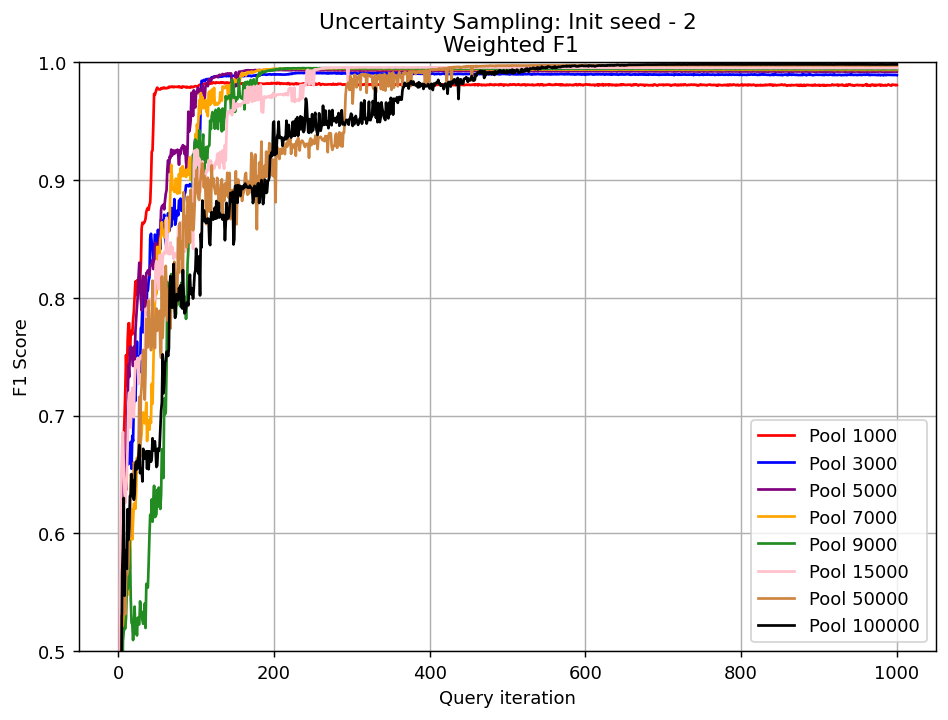

Next Init ...
Loading ./result_pickles/uncert_5_times_ref/10_init/10_init_1000_pool.pkl ...
Loading ./result_pickles/uncert_5_times_ref/10_init/10_init_3000_pool.pkl ...
Loading ./result_pickles/uncert_5_times_ref/10_init/10_init_5000_pool.pkl ...
Loading ./result_pickles/uncert_5_times_ref/10_init/10_init_7000_pool.pkl ...
Loading ./result_pickles/uncert_5_times_ref/10_init/10_init_9000_pool.pkl ...
Loading ./result_pickles/uncert_5_times_ref/10_init/10_init_15000_pool.pkl ...
Loading ./result_pickles/uncert_5_times_ref/10_init/10_init_50000_pool.pkl ...
Loading ./result_pickles/uncert_5_times_ref/10_init/10_init_100000_pool.pkl ...


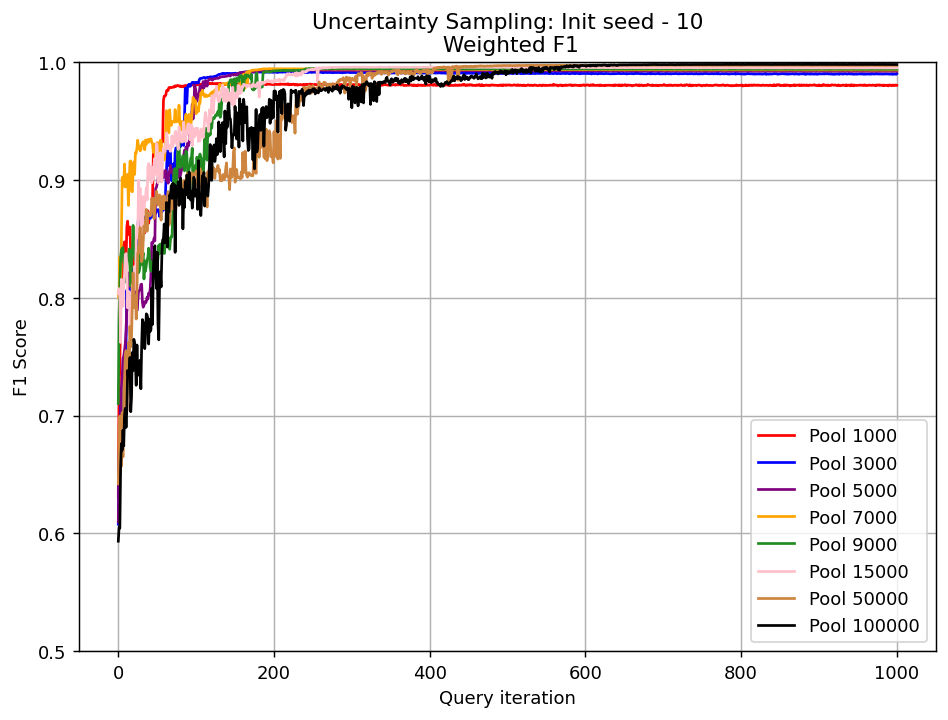

Next Init ...
Loading ./result_pickles/uncert_5_times_ref/40_init/40_init_1000_pool.pkl ...
Loading ./result_pickles/uncert_5_times_ref/40_init/40_init_3000_pool.pkl ...
Loading ./result_pickles/uncert_5_times_ref/40_init/40_init_5000_pool.pkl ...
Loading ./result_pickles/uncert_5_times_ref/40_init/40_init_7000_pool.pkl ...
Loading ./result_pickles/uncert_5_times_ref/40_init/40_init_9000_pool.pkl ...
Loading ./result_pickles/uncert_5_times_ref/40_init/40_init_15000_pool.pkl ...
Loading ./result_pickles/uncert_5_times_ref/40_init/40_init_50000_pool.pkl ...
Loading ./result_pickles/uncert_5_times_ref/40_init/40_init_100000_pool.pkl ...


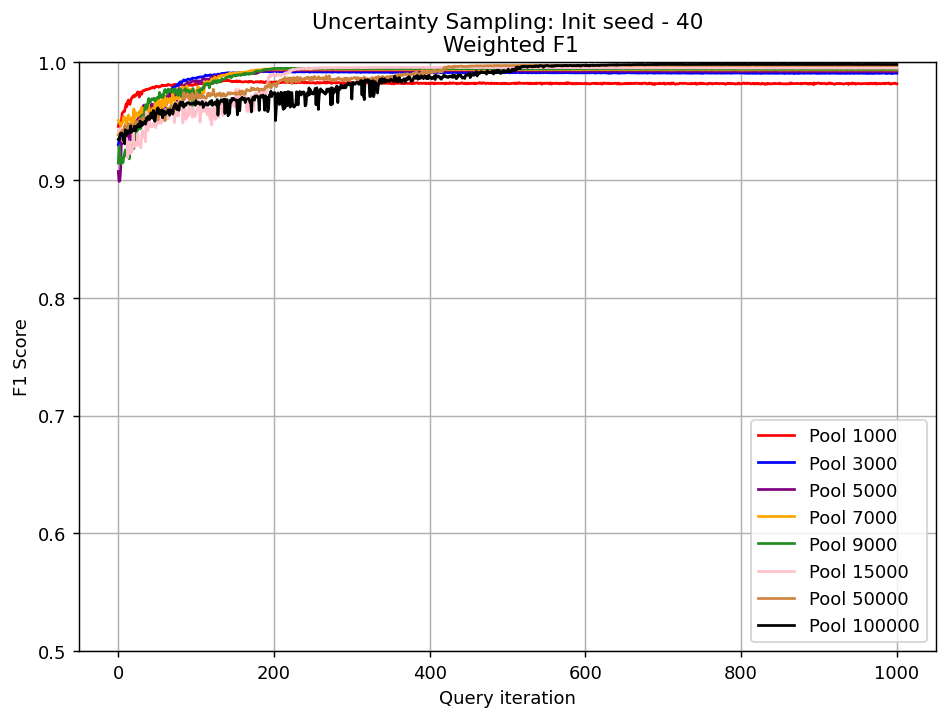

Next Init ...
Loading ./result_pickles/uncert_5_times_ref/200_init/200_init_1000_pool.pkl ...
Loading ./result_pickles/uncert_5_times_ref/200_init/200_init_3000_pool.pkl ...
Loading ./result_pickles/uncert_5_times_ref/200_init/200_init_5000_pool.pkl ...
Loading ./result_pickles/uncert_5_times_ref/200_init/200_init_7000_pool.pkl ...
Loading ./result_pickles/uncert_5_times_ref/200_init/200_init_9000_pool.pkl ...
Loading ./result_pickles/uncert_5_times_ref/200_init/200_init_15000_pool.pkl ...
Loading ./result_pickles/uncert_5_times_ref/200_init/200_init_50000_pool.pkl ...
Loading ./result_pickles/uncert_5_times_ref/200_init/200_init_100000_pool.pkl ...


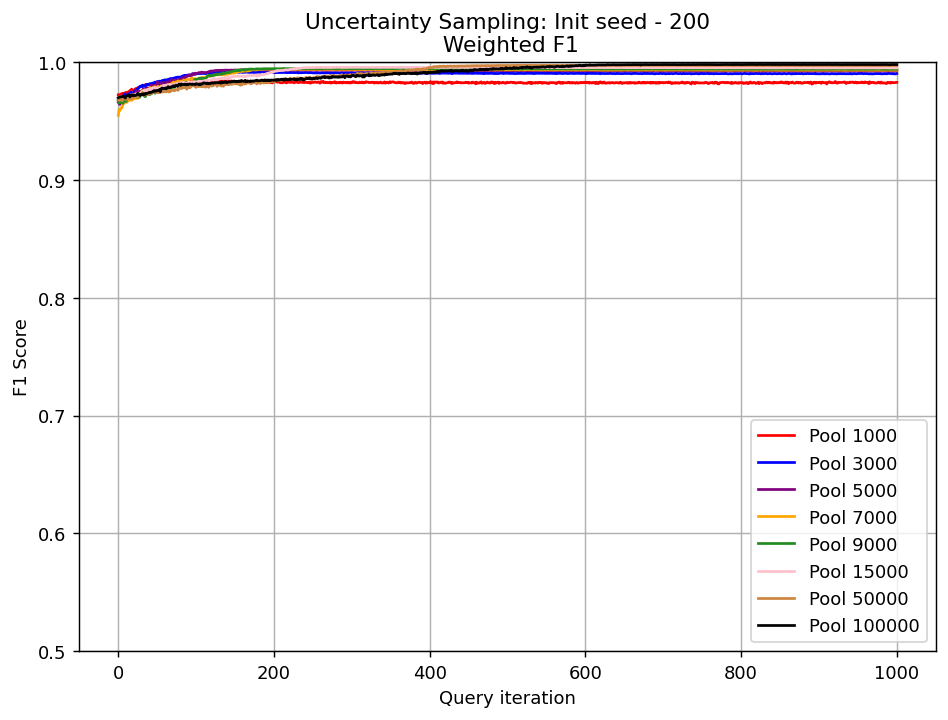

Next Init ...


In [23]:
make_graph('Weighted', 'F1')